### Install needs

In [304]:
# pip install biopython bio networkx

### Imports

In [305]:
from Bio.Phylo.TreeConstruction import ParsimonyTreeConstructor, ParsimonyScorer
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio.Phylo.Applications import PhymlCommandline
from collections import defaultdict
import matplotlib.pyplot as plt
from grammar.pcfg import PCFG
from itertools import product
from scipy.linalg import expm
from copy import deepcopy
from Bio import Phylo
import networkx as nx
from math import log
import numpy as np
import shutil
import os

### Stockholm to Phylip format conversion
https://www.hiv.lanl.gov/content/sequence/FORMAT_CONVERSION/form.html

### Get Maximum Likelihood phylogenetic tree
http://www.atgc-montpellier.fr/phyml/

### Get From files

##### Sequences

In [306]:
def read_sequences (filename: str):
    first_ln = False
    num_seq = 0
    len_seq = 0
    
    seq_dict = defaultdict(str)
    
    with open(filename) as file:
        for line in file:
            line = line.strip().split()
            if len(line) == 2:
                if first_ln == False:
                    num_seq = int(line[0])
                    len_seq = int(line[1])
                    first_ln = True
                else:
                    if len(line[1]) == len_seq and num_seq != 0:
                        seq_dict[line[0]] = line[1]
                        num_seq -= 1
                    else: 
                        raise ValueError("Invalid file structure")
    return seq_dict

##### Tree

In [307]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            if index == 0:
                clade.name = "root"
            else:
                clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Phylo.to_networkx(Tree)

##### Structure

In [308]:
def read_structure(filename: str):
    with open(filename) as file:
        return file.readline().strip()

In [309]:
def simplify_struct(structure: str, filename=""):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for i in range(len(structure)):
        if structure[i] in pairing_chars:
            simplified += "d "
        else:
            simplified += "s "
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)
    
    return simplified

### Validate Sequence String

In [310]:
def is_valid_str(input_string, valid_characters = ["A", "C", "G", "U"]):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

### Get Pairing Charecter

In [311]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [312]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [313]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

### Calculate frequency

In [314]:
def calc_frequencies (seq_dict: defaultdict, structure, known_chars = ["A", "C", "G", "U"]):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    # Stack of unpaired nucleotides (structure symbol, nocleotide)
    unpaired_nucleotides = []
    
    for _, sequence in seq_dict.items():
        for index, nucleotide in enumerate(sequence): 
            structure_symbol = structure[index]
            # Having a charecter [ '(', '[', '{', '<' ]
            if is_pair_start(structure_symbol):
                unpaired_nucleotides.append((structure_symbol, nucleotide))
            # Having a charecter [ ')', ']', '}', '>' ]
            elif is_pair_end(structure_symbol):
                unpaired_nucleotide = unpaired_nucleotides.pop()
                if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                    paired_nucleotide = unpaired_nucleotide[1] + nucleotide
                    if is_valid_str(paired_nucleotide, known_chars):
                        paired_nucleotides[paired_nucleotide] += 1
                        paired_nucleotides[paired_nucleotide[::-1]] += 1
                        total_paireds += 1
                else:
                    raise ValueError('Invalid pattern in structure')
            # Having a non-pairing charecter
            else:
                if is_valid_str(nucleotide, known_chars):
                    single_nucleotides[nucleotide] += 1
                    total_singles += 1

    total = total_singles + (total_paireds * 2)
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / (total_paireds * 2)
        
    return (
        single_nucleotides,
        paired_nucleotides,
        total_singles / total,
        (total_paireds * 2) / total
    )

### Find time two sequences

In [315]:
def find_node_by_name(graph, name_str):
    return [node for _, node in enumerate(list(graph.nodes)) if node.name==name_str][0]

In [316]:
def calculate_time(graph, sourceName, targetName):
    source_node = find_node_by_name(graph, sourceName)
    target_node = find_node_by_name(graph, targetName)
    
    return nx.shortest_path_length(
            graph, 
            source= source_node, 
            target= target_node, 
            weight= "weight"
        )

### Simularity Percentage

In [317]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

### Calculate Rate Matrix
$$r_{XY}=\frac{c_{XY}}{2p_xP_s\sum_{P} N_Pt_P}$$

In [318]:
def calc_rate_values(
    graph, 
    seq_dict: defaultdict, 
    structure, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob, 
    known_chars = ["A", "C", "G", "U"]
):
    seq_list = [(k, v) for k, v in seq_dict.items()]
    unpaired_nucleotides = []
    k_value = 0
    
    single_mutation_count = defaultdict(float)
    paired_mutation_count = defaultdict(float)
    
    for i in range(len(seq_list)):
        temp_single_mutation_count = defaultdict(int)
        temp_paired_mutation_count = defaultdict(int)
        
        same_first_sequence_count = 0
        
        for j in range(len(seq_list)):
            columns_count = 0
            differs_count = 0
            
            # first_name = seq_list[i][0]
            # second_name = seq_list[j][0]
            first_sequence = seq_list[i][1]
            second_sequence = seq_list[j][1]
            # The pair should contain diffrent 
            # sequence with at least %85 simularity.
            if i != j and check_simularity(first_sequence, second_sequence):
                same_first_sequence_count += 1
                for k in range(len(first_sequence)): 
                    structure_symbol = structure[k]
                    # Having a charecter [ '(', '[', '{', '<' ]
                    if is_pair_start(structure_symbol):
                        unpaired_nucleotides.append((
                            structure_symbol, 
                            first_sequence[k], 
                            second_sequence[k]
                        ))
                    # Having a charecter [ ')', ']', '}', '>' ]
                    elif is_pair_end(structure_symbol):
                        unpaired_nucleotide = unpaired_nucleotides.pop()
                        first_pair = unpaired_nucleotide[1] + first_sequence[k]
                        second_pair = unpaired_nucleotide[2] + second_sequence[k]
                        if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                            if (is_valid_str(first_pair, known_chars) 
                            and is_valid_str(second_pair, known_chars)):
                                columns_count += 2
                                if first_pair != second_pair:
                                    differs_count += 2
                                    temp_paired_mutation_count[(first_pair, second_pair)] += 1
                                    temp_paired_mutation_count[(first_pair[::-1], second_pair[::-1])] += 1
                        else:
                            raise ValueError('Invalid pattern in structure')    
                    # Having a non-pairing charecter
                    else:
                        if (is_valid_str(first_sequence[k], known_chars) 
                        and is_valid_str(second_sequence[k], known_chars)):
                            columns_count += 1
                            if first_sequence[k] != second_sequence[k]:
                                differs_count += 1
                                
                                temp_single_mutation_count[(
                                    first_sequence[k], 
                                    second_sequence[k],
                                )] += 1
                # k_value += (calculate_time(graph, first_name, second_name) * columns_count)
                k_value += ((differs_count / columns_count) * columns_count)
        
        if same_first_sequence_count > 0:
            for key in temp_single_mutation_count:
                single_mutation_count[key] += (temp_single_mutation_count[key] 
                                               / same_first_sequence_count)
            for key in temp_paired_mutation_count:
                paired_mutation_count[key] += (temp_paired_mutation_count[key] 
                                               / same_first_sequence_count)
                
    single_chars = known_chars
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_values = defaultdict(float)
    paired_rate_values = defaultdict(float)
            
    for i in single_chars:
        single_rate_values[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_values[(i,j)] = (single_mutation_count[(i,j)] 
                                             / (singles_prob * single_frequencies[i] * k_value))
                single_rate_values[(i,i)] = single_rate_values[(i,i)] - single_rate_values[(i,j)]

    for i in paired_chars:
        paired_rate_values[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_values[(i,j)] = ((paired_mutation_count[(i,j)] * 2)
                                             / (paireds_prob * paired_frequencies[i] * k_value))
                paired_rate_values[(i,i)] = paired_rate_values[(i,i)] - paired_rate_values[(i,j)]
    
    return single_rate_values, paired_rate_values  

### Probablity matrix From Q matrix

$$P = e^{Qt}$$

In [319]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"]):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probablity_rate_matrix = expm(mutation_rate_matrix * time)
    
    probablity_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probablity_rate_values[(i_value, j_value)] = probablity_rate_matrix[i_index,j_index]
    
    return probablity_rate_values

### Estimate Tree

In [320]:
class MutationNode(Phylo.BaseTree.Clade): 
    def __init__(self, name, sequence, **kwargs): 
        super(MutationNode, self).__init__(**kwargs) 
        
        self.name = name 
        self.sequence = [nucleotide for nucleotide in sequence]

In [321]:
def distance(node1, node2):
    columns_count = 0
    differs_count = 0
    for i in range(len(node1.sequence)):
        if (is_valid_str(node1.sequence[i]) 
        and is_valid_str(node2.sequence[i])):
            columns_count += 1
            if node1.sequence[i] != node2.sequence[i]:
                differs_count += 1
            
    return differs_count / columns_count                                             

In [322]:
def create_tree(names, sequences):
  if len(names) < 2:
    return None
  
  nodes = [MutationNode(
      name=names[i], 
      sequence=sequences[i]
    ) for i in range(len(names))
  ]
  
  matrix = []
   
  for i, node1 in enumerate(nodes): 
    i_vector = [] 
    for j, node2 in enumerate(nodes): 
      if i < j: 
        continue 
      i_vector.append(distance(node1, node2)) 
    matrix.append(i_vector)
    
  distance_matrix = DistanceMatrix(names, matrix) 
  constructor = DistanceTreeConstructor() 
  nj_tree = constructor.nj(distance_matrix)
  
  nj_tree.ladderize() 
  
  os.mkdir(".\\tmp")
  Phylo.write(nj_tree, "tmp\\nj_tree.nwk", "newick")

  output_tree = nj_tree

  if len(names) > 2:
    phylip_file = "tmp\\sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[i])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    !phyml -i tmp/sequences.phylip -u tmp/nj_tree.nwk -m GTR
    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')

    output_tree.root_at_midpoint()
  elif len(names) == 2:
    output_tree.root_with_outgroup(output_tree.clade)
    output_tree.rooted = True
    output_tree.weight = 1.0
  
  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree(".\\tmp")
  Phylo.write(output_tree, "outputs\\tree.nwk", "newick")
  
  Phylo.draw(output_tree)
  nx.draw(Phylo.to_networkx(output_tree), with_labels=True)
  
  return output_tree

### Get columns probablity

In [323]:
def pattern_successor(pattern):
    order = ["A", "C", "G", "U"]
    last_filled = len(pattern) - 1
    gap_shifted = False

    for i in range(len(pattern)):
        if pattern[i] != "-":
            if pattern[i] == order[-1]:
                pattern[i] = order[0]
            else:
                index = order.index(pattern[i])
                pattern[i] = order[index + 1]
                return pattern
    
    indices = [i for i, x in enumerate(pattern) if x == '-']
    
    for index in indices[::-1]:
        if index == last_filled and pattern[index] == "-":
            last_filled -= 1
            pattern[index] = order[0]
            continue
        elif index != last_filled and pattern[index] == "-":
            pattern[index] = order[0]
            for shifte in range(len(pattern) - last_filled):
                pattern[(index + shifte + 1)] = "-"
            gap_shifted = True
            break
    
    if not gap_shifted:
        if (len(pattern) - last_filled) == (len(pattern) + 1):
            return []
        else:
            for index in range(len(pattern) - last_filled):
                pattern[index] = "-"
    
    return pattern

In [324]:
def add_gap_probablities(columns_probablity, height, paired = False):
    pattern = (["U"] * height * 2) if paired else (["U"] * height)
    
    while pattern_successor(pattern) != []:
        index = pattern.index("-")
        order = ["A", "C", "G", "U"]
        probablity = 0
        for n in order:
            pattern[index] = n
            if paired:
                    probablity += columns_probablity[tuple([
                        pattern[i] + pattern[i+1] for i in range(0, len(pattern), 2)
                    ])]
            else:
                probablity += columns_probablity[tuple(pattern)]
        pattern[index] = "-"
        
        if paired:
            columns_probablity[tuple([
                pattern[i] + pattern[i+1] for i in range(0, len(pattern), 2)
            ])] = probablity
            
        else:
            columns_probablity[tuple(pattern)] = probablity
    columns_probablity

In [325]:
def post_order_traversal(tree, current_node, possible_values, rate_values): 
    current_columns_probablity = defaultdict(lambda: defaultdict(float))
    
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probablity:
                perv_columns_probablity = deepcopy(current_columns_probablity)
                current_columns_probablity.clear()
                
                for left_column in perv_columns_probablity:
                    for root in perv_columns_probablity[left_column]:
                        for child_value in possible_values:
                            current_columns_probablity[left_column + (child_value ,)][root] = (
                                mutation_probablities[(root, child_value)] * 
                                perv_columns_probablity[left_column][root]
                            )
                perv_columns_probablity.clear()
            
            # haven't filled with any branch in last iteration
            else:
                for mutation in mutation_probablities:
                    current_columns_probablity[(mutation[1] ,)][mutation[0]] = mutation_probablities[mutation]
            
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probablity = post_order_traversal(tree, child, possible_values, rate_values)
            
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probablity:
                perv_columns_probablity = deepcopy(current_columns_probablity)
                current_columns_probablity.clear()
                
                for left_column in perv_columns_probablity:
                    for root in perv_columns_probablity[left_column]:
                        for right_column in inner_columns_probablity:
                            current_columns_probablity[left_column + right_column][root] = sum(
                                (
                                    mutation_probablities[(root, inner_root)] * 
                                    inner_columns_probablity[right_column][inner_root] * 
                                    perv_columns_probablity[left_column][root]
                                ) for inner_root in inner_columns_probablity[right_column])
                
                perv_columns_probablity.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in possible_values:
                    for column in inner_columns_probablity:
                        current_columns_probablity[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probablity[column][inner_root]
                            ) for inner_root in inner_columns_probablity[column]
                        )
                    
    return current_columns_probablity

In [326]:
def get_columns_probablity(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
):
    single_possible_values = ['A', 'C', 'G', 'U']
    paired_possible_values = [c1 + c2 for c1 in single_possible_values for c2 in single_possible_values]
    
    __single_columns_probablity = post_order_traversal(
        tree, 
        tree.root, 
        single_possible_values, 
        single_rate_values
    )
    single_columns_probablity = defaultdict(float)
    for column in __single_columns_probablity:
        single_columns_probablity[column] = sum(
            __single_columns_probablity[column][root] 
            * single_frequencies[root] for root in single_possible_values
        )
    __single_columns_probablity.clear()
    
    __paired_columns_probablity = post_order_traversal(
        tree, 
        tree.root, 
        paired_possible_values, 
        paired_rate_values
    )
    paired_columns_probablity = defaultdict(float)
    for column in __paired_columns_probablity:
        paired_columns_probablity[column] = sum(
            __paired_columns_probablity[column][root] 
            * paired_frequencies[root] for root in paired_possible_values
        )
    __paired_columns_probablity.clear()
    
    add_gap_probablities(single_columns_probablity, tree.count_terminals(), paired=False)
    add_gap_probablities(paired_columns_probablity, tree.count_terminals(), paired=True)
    
    return single_columns_probablity, paired_columns_probablity

### Save PCFG

In [327]:
def save_pcfg(pcfg, filename):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with open(f"{filename}.pcfg", "w+") as pcfg_file:
        for A, B, C in binary_rules:
            pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}\n")
            
        for A, w in unary_rules:
            pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}\n")

### Extend grammar

In [328]:
def extend_grammar(
    pcfg,
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "Dm" and B == "Dl" and C == "F":
                for column, prob in single_column_probs.items():
                    term = str(column).replace(" ", "")
                    pcfg_file.write(f"{A+term} -> Dl{term} F {pcfg.q[(A, B, C)]}" + "\n")
                    cfg_file.write(f"{A+term} -> Dl{term} F" + "\n")
            elif B == "Dm" and C == "Dr":
                for column, prob in paired_column_probs.items():
                    left = str(tuple(
                        pair[0] for pair in column if pair
                    )).replace(" ", "")
                    right = str(tuple(
                        pair[1] for pair in column if pair
                    )).replace(" ", "")
                    pcfg_file.write(f"{A} -> Dm{left} Dr{right} {pcfg.q[(A, B, C)] * prob}" + "\n")
                    cfg_file.write(f"{A} -> Dm{left} Dr{right}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    term = str(column).replace(" ", "")
                    pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                    cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    term = str(column).replace(" ", "")
                    pcfg_file.write(f"{A+term} -> {term} {pcfg.q[(A, w)]}" + "\n")
                    cfg_file.write(f"{A+term} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

### Get CYK tree

In [329]:
predicted_struct = {}

def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
        
    if start == end and table[(start, end, non_terminal)]:
        if non_terminal.startswith("Dl"):
            predicted_struct[start] = "("
        elif non_terminal.startswith("Dr"):
            predicted_struct[start] = ")"
        else:
            predicted_struct[start] = "."

    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

In [330]:
def draw_parse_tree(table, start_point, end_point):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    
    pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
    nx.draw(
        parse_tree, 
        pos, 
        with_labels=True, 
        node_color='lightblue', 
        node_size=5, 
        font_size=.0001
    )
    nx.draw_networkx_nodes(
        parse_tree, 
        pos, 
        nodelist=[(start_point, end_point, "S")], 
        node_color='green', 
        node_size=5
    )

### Get total sequence

In [331]:
def get_total_sequence(seq_dict, aligned_list):
    total_sequence = ""
    for i in range(len(seq_dict[aligned_list[0]])):
        column = tuple([
            seq_dict[seq_name][i] for seq_name in aligned_list
        ])
        total_sequence += str(column).replace(" ", "") + " "
    return total_sequence

# Test

### Estimate PCFG on structure 

In [332]:
# Train for first time
# pcfg = PCFG("primaries\\Structure.cfg")
# pcfg.estimate("primaries\\RF03000.train", iter_num=20)

In [333]:
# Read from trained file
pcfg = PCFG("primaries\\Structure.cfg", "primaries\\Structure.pcfg")

defaultdict(<class 'float'>, {('S', 'L', 'S'): 0.9213480439012321, ('S', 'Dm', 'Dr'): 0.017930477456403877, ('F', 'Dm', 'Dr'): 0.8171596601964021, ('F', 'L', 'S'): 0.18284033980359785, ('L', 'Dm', 'Dr'): 0.05248219336729697, ('Dm', 'Dl', 'F'): 1.0, ('S', 's'): 0.060721478642363845, ('L', 's'): 0.9475178066327031, ('Dl', 'd'): 1.0, ('Dr', 'd'): 1.0})


### Calculate mutation rate and frequencies

In [334]:
structure = read_structure("primaries\\RF03000.structure")
seq_dict = read_sequences("primaries\\RF03000.phylip")
graph = read_tree("primaries\\RF03000.nwk")
simplified = simplify_struct(structure, "primaries\\RF03000")

(single_frequencies, 
 paired_frequencies, 
 singles_prob, 
 paireds_prob) = calc_frequencies(seq_dict, structure)

(single_rate_values, 
 paired_rate_values) = calc_rate_values(
    graph, 
    seq_dict, 
    structure, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob
)

print(single_rate_values, paired_rate_values)

defaultdict(<class 'float'>, {('A', 'A'): -0.24205201320318828, ('A', 'C'): 0.07258261721721225, ('A', 'G'): 0.08303234639618763, ('A', 'U'): 0.0864370495897884, ('C', 'C'): -0.5878627543513866, ('C', 'A'): 0.18651500430280654, ('C', 'G'): 0.06033312050634316, ('C', 'U'): 0.3410146295422368, ('G', 'G'): -0.4485489381569704, ('G', 'A'): 0.2603821500412345, ('G', 'C'): 0.07221536192549864, ('G', 'U'): 0.11595142619023725, ('U', 'U'): -0.4538884652883678, ('U', 'A'): 0.14612090947726308, ('U', 'C'): 0.23140840228994275, ('U', 'G'): 0.07635915352116196}) defaultdict(<class 'float'>, {('AA', 'AA'): -1.202005347593583, ('AA', 'AC'): 0.10273549979432332, ('AA', 'AG'): 0.0, ('AA', 'AU'): 0.3441639243109832, ('AA', 'CA'): 0.10273549979432332, ('AA', 'CC'): 0.0, ('AA', 'CG'): 0.12841937474290416, ('AA', 'CU'): 0.0, ('AA', 'GA'): 0.0, ('AA', 'GC'): 0.12841937474290416, ('AA', 'GG'): 0.0, ('AA', 'GU'): 0.0, ('AA', 'UA'): 0.3441639243109832, ('AA', 'UC'): 0.0, ('AA', 'UG'): 0.0, ('AA', 'UU'): 0.051

### Calculat probablities







                                 ..........................                                      
 ooooooooooooooooooooooooooooo        CURRENT SETTINGS        ooooooooooooooooooooooooooooooooooo
                                 ..........................                                      

                . Sequence filename:				 sequences.phylip
                . Data type:					 dna
                . Alphabet size:				 4
                . Sequence format:				 interleaved
                . Number of data sets:				 1
                . Nb of bootstrapped data sets:			 0
                . Compute approximate likelihood ratio test:	 yes (SH-like branch supports)
                . Model name:					 GTR
                . Proportion of invariable sites:		 0.000000
                . Number of subst. rate categs:			 4
                . Gamma distribution parameter:			 estimated
                . 'Middle' of each rate class:			 mean
                . Nucleotide equilibrium frequencies:	

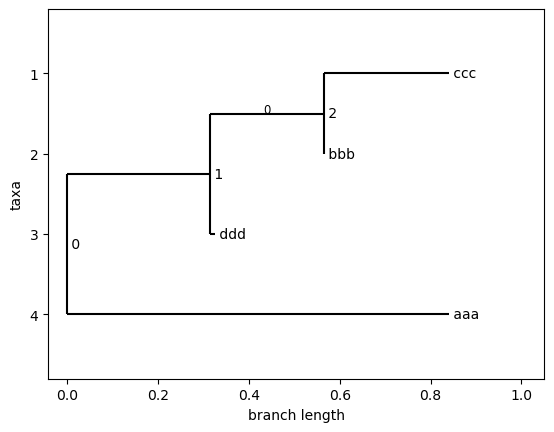

16.0

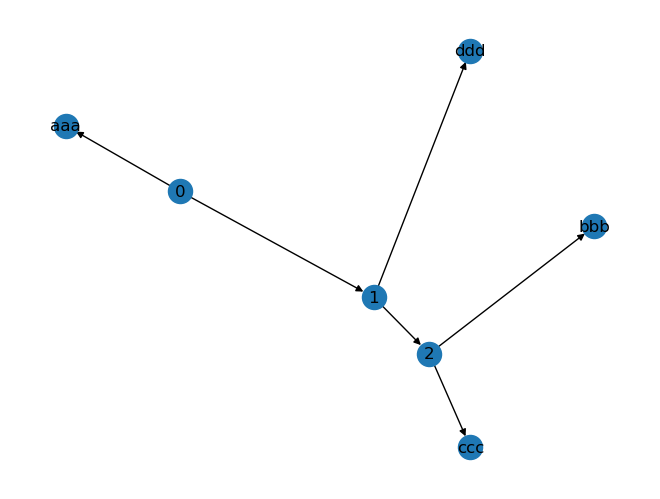

In [343]:
estimated_tree = create_tree(["aaa", "bbb", "ccc", "ddd"], ["UUCGC", "UAGCG", "UAGCU", "UAGGG"])
(
    single_columns_probablity, 
    paired_columns_probablity
) = get_columns_probablity(
    estimated_tree, 
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values
)
a = 0
for column in single_columns_probablity:
    a += single_columns_probablity[column]
a

In [336]:
# extend_grammar(
#     pcfg,
#     single_column_probs, 
#     paired_column_probs,
#     filename="outputs\\Extended"
# )

In [337]:
# # Read from extended file
# extended_pcfg = PCFG("outputs\\Extended.cfg", "outputs\\Extended.pcfg")

In [338]:
# total_sequence = get_total_sequence(seq_dict, aligned_list)
# _, table = extended_pcfg.sentence_prob(total_sequence)

In [339]:
# draw_parse_tree(table, 1, len(seq_dict[aligned_list[0]]))
# plt.savefig("plot.png", dpi=1000)

In [340]:
# struct = ""
# for key, val in predicted_struct.items():
#     struct += val
# struct

In [341]:
# estimate_tree(["ACUUG", "ACCUG"], [[-1, .6, .2, .2],
#                                    [.6, -1, .2, .2],
#                                    [.2, .6, -1, .2],
#                                    [.2, .6, .2, -1]])